In [1]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57344/57026 [==============================] - 0s 0us/step


In [2]:
train_data.shape

(404, 13)

In [0]:
# 数据正则化。每个特征的数据范围不同会增大学习难度。
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [0]:
from keras import models
from keras import layers
def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, activation="relu", input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(64, activation="relu"))
  # 最后一层只有一个神经元，且没有激活函数，因此是一个线性层。
  model.add(layers.Dense(1))
  # mse: mean squared error; mae: mean absolute error
  model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
  return model

In [8]:
# K折交叉验证
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 500
all_mae_history = []

for i in range(k):
  print("processing fold #", i)
  val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]

  partial_train_data = np.concatenate((train_data[:i * num_val_samples], train_data[(i+1) * num_val_samples:]), axis=0)
  partial_train_targets = np.concatenate((train_targets[:i * num_val_samples], train_targets[(i+1) * num_val_samples:]), axis=0)

  model = build_model()
  # verbose=0, in silent mode
  history = model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0, validation_data=(val_data, val_targets))
  all_mae_history.append(history.history["val_mean_absolute_error"])


processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [0]:
all_mae_history = np.array(all_mae_history)

In [0]:
mean_mae_history = all_mae_history.mean(axis=0)

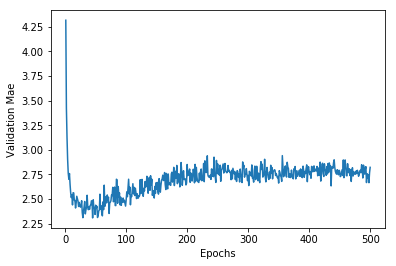

In [15]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(mean_mae_history)+1), mean_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation Mae")
plt.show()

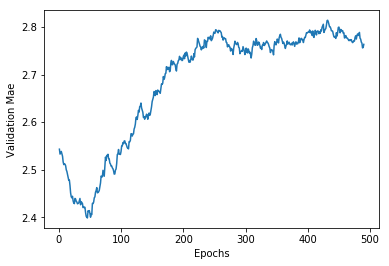

In [18]:
# 原图不易观察，稍作修改。此处利用了指数移动平均方法，移动平均可抚平短期波动，反映出长期趋势。
# 详见https://zh.wikipedia.org/wiki/%E7%A7%BB%E5%8B%95%E5%B9%B3%E5%9D%87， https://zhuanlan.zhihu.com/p/38276041
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smoothed_mae_history = smooth_curve(mean_mae_history[10:])
plt.plot(range(1, len(smoothed_mae_history) + 1), smoothed_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation Mae")
plt.show()

In [20]:
model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 3ms/step


In [21]:
test_mae_score

2.974073232388964